In [1]:
import pandas as pd
import glob
import os
from tqdm.notebook import tqdm
from datetime import datetime
from copy import copy

from trenchant_utils import get_metric

2022-03-03 23:22:40.520630: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# agnostic variables
metrics = ['precision', 'recall', 'f1']
average = 'macro'
edge_types = ['event_trend']
experiments = ['not-tuned', 'fine-tuned-twelve-weeks-corn', 'fine-tuned-twenty_four-weeks-corn', 'fine-tuned-fourty_eight-weeks-corn',
        'fine-tuned-twelve-weeks-soy', 'fine-tuned-twenty_four-weeks-soy', 'fine-tuned-fourty_eight-weeks-soy', 
        'fine-tuned-three-months-corn', 'fine-tuned-six-months-corn', 'fine-tuned-twelve-months-corn',
        'fine-tuned-three-months-soy', 'fine-tuned-six-months-soy', 'fine-tuned-twelve-months-soy']
labels = [None, [0], [1], [2], [3]]

In [3]:
def selector(experiment, path):
    if experiment == 'not-tuned':
        algorithms = ['regularization', 'deep_walk', 'node2vec', 'line', 'struc2vec', 'metapath2vec', 'gcn']
        intervals = ['week', 'month']
        commodities = ['corn', 'soybean']
        time_windows = {'month': [3, 6, 12], 'week': [12, 24, 48]}
        path = f'{path}pred_iterative_new/'
        all_files = glob.glob(os.path.join(path, "*.csv"))

    else:
        algorithms = ['regularization-tuned']
        fine_tune_dict = {
            'fine-tuned-twelve-weeks-corn': {'interval': 'week', 'commodity': 'corn', 'time_window': 12},
            'fine-tuned-twenty_four-weeks-corn': {'interval': 'week', 'commodity': 'corn', 'time_window': 24},
            'fine-tuned-fourty_eight-weeks-corn': {'interval': 'week', 'commodity': 'corn', 'time_window': 48},
            'fine-tuned-twelve-weeks-soy': {'interval': 'week', 'commodity': 'soybean', 'time_window': 12},
            'fine-tuned-twenty_four-weeks-soy': {'interval': 'week', 'commodity': 'soybean', 'time_window': 24},
            'fine-tuned-fourty_eight-weeks-soy': {'interval': 'week', 'commodity': 'soybean', 'time_window': 48},
            'fine-tuned-three-months-corn': {'interval': 'month', 'commodity': 'corn', 'time_window': 3},
            'fine-tuned-six-months-corn': {'interval': 'month', 'commodity': 'corn', 'time_window': 6},
            'fine-tuned-twelve-months-corn': {'interval': 'month', 'commodity': 'corn', 'time_window': 12},
            'fine-tuned-three-months-soy': {'interval': 'month', 'commodity': 'soybean', 'time_window': 3},
            'fine-tuned-six-months-soy': {'interval': 'month', 'commodity': 'soybean', 'time_window': 6},
            'fine-tuned-twelve-months-soy': {'interval': 'month', 'commodity': 'soybean', 'time_window': 12},
        }
        intervals = [fine_tune_dict[experiment]['interval']]
        commodities = [fine_tune_dict[experiment]['commodity']]
        time_windows = {fine_tune_dict[experiment]['interval']: [fine_tune_dict[experiment]['time_window']]}
        path = f'{path}pred_iterative_tuned/'
        all_files = glob.glob(os.path.join(path, "*.csv"))

    return algorithms, intervals, commodities, time_windows, path, all_files

def class_distribution(true):
    return_dict = {
        'big_down': true[true == 0].shape[0],
        'down': true[true == 1].shape[0],
        'up': true[true == 2].shape[0],
        'big_up': true[true == 3].shape[0],
    }
    return return_dict
    

In [4]:
# running
results_dict = {'metric': [], 'algorithm': [], 'interval': [], 'commodity': [], 'time_window': [], 'edge_type': [], 'label': [], 'class_distribution': [], 'value': []}
for experiment in tqdm(experiments):
    algorithms, intervals, commodities, time_windows, path, all_files = selector(experiment, '/media/pauloricardo/basement/commodities_usecase/')
    for interval in intervals:
        for commodity in commodities:
            for time_window in time_windows[interval]:
                true_path = '{}true_{}_{}_{}.csv'.format(path, interval, commodity, time_window)
                if true_path in all_files:
                    true = pd.read_csv(true_path)['0']
                    class_distribution_str = str(class_distribution(true))
                    for algorithm in algorithms:        
                        for i in range(10):
                            pred_path = '{}lstm_{}_{}_{}_{}_{}.csv'.format(path, algorithm, interval, commodity, time_window, i)
                            if pred_path in all_files:
                                pred = pd.read_csv(pred_path)['0']
                                for metric in metrics:
                                    for edge_type in edge_types:
                                        for label in labels: 
                                            results_dict['metric'].append(metric)
                                            results_dict['algorithm'].append(algorithm)
                                            results_dict['interval'].append(interval)
                                            results_dict['commodity'].append(commodity)
                                            results_dict['time_window'].append(time_window)
                                            results_dict['edge_type'].append(edge_type)
                                            results_dict['label'].append(str(label))
                                            results_dict['class_distribution'].append(copy(class_distribution_str))
                                            results_dict['value'].append(get_metric(metric, true, pred, average=average, labels=label))

results_df = pd.DataFrame(results_dict)
metric_order = {'f1': 0, 'precision': 1, 'recall': 2}
results_df['metric'] = pd.Categorical(results_df['metric'], 
                         categories=sorted(metric_order, key=metric_order.get), 
                         ordered=True)
results_df.sort_values(by=['interval', 'commodity', 'algorithm', 'time_window', 'metric'], inplace=True)
results_df = results_df.reset_index(drop=True)
results_df['metric'] = results_df['metric'].astype(str)
results_df

  0%|          | 0/13 [00:00<?, ?it/s]

/home/pauloricardo/anaconda3/envs/masters/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pauloricardo/anaconda3/envs/masters/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pauloricardo/anaconda3/envs/masters/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pauloricardo/anaconda3/envs/masters/lib

,metric,algorithm,interval,commodity,time_window,edge_type,label,class_distribution,value
0,f1,deep_walk,month,corn,3,event_trend,None,"{'big_down': 0, 'down': 0, 'up': 61, 'big_up': 0}",0.306818
1,f1,deep_walk,month,corn,3,event_trend,[0],"{'big_down': 0, 'down': 0, 'up': 61, 'big_up': 0}",0.000000
2,f1,deep_walk,month,corn,3,event_trend,[1],"{'big_down': 0, 'down': 0, 'up': 61, 'big_up': 0}",0.000000
3,f1,deep_walk,month,corn,3,event_trend,[2],"{'big_down': 0, 'down': 0, 'up': 61, 'big_up': 0}",0.613636
4,f1,deep_walk,month,corn,3,event_trend,[3],"{'big_down': 0, 'down': 0, 'up': 61, 'big_up': 0}",0.000000
...,...,...,...,...,...,...,...,...,...
14395,recall,struc2vec,week,soybean,48,event_trend,None,"{'big_down': 46, 'down': 93, 'up': 101, 'big_u...",0.232839
14396,recall,struc2vec,week,soybean,48,event_trend,[0],"{'big_down': 46, 'down': 93, 'up': 101, 'big_u...",0.108696
14397,recall,struc2vec,week,soybean,48,event_trend,[1],"{'big_down': 46, 'down': 93, 'up': 101, 'big_u...",0.333333
14398,recall,struc2vec,week,soybean,48,event_trend,[2],"{'big_down': 46, 'down': 93, 'up': 101, 'big_u...",0.178218


In [5]:
results_df_group = results_df.groupby(by=['metric', 'algorithm', 'interval', 'commodity', 'time_window', 'edge_type', 'label', 'class_distribution'], as_index=False).mean()
results_df_group['std'] = results_df.groupby(by=['metric', 'algorithm', 'interval', 'commodity', 'time_window', 'edge_type', 'label', 'class_distribution'], as_index=False).std()['value']
#results_df_group.to_csv('/media/pauloricardo/basement/commodities_usecase/results_tuned/results_{}.csv'.format(datetime.now()), index=False)
results_df_group

,metric,algorithm,interval,commodity,time_window,edge_type,label,class_distribution,value,std
0,f1,deep_walk,month,corn,3,event_trend,None,"{'big_down': 0, 'down': 0, 'up': 61, 'big_up': 0}",0.354290,0.051317
1,f1,deep_walk,month,corn,3,event_trend,[0],"{'big_down': 0, 'down': 0, 'up': 61, 'big_up': 0}",0.000000,0.000000
2,f1,deep_walk,month,corn,3,event_trend,[1],"{'big_down': 0, 'down': 0, 'up': 61, 'big_up': 0}",0.000000,0.000000
3,f1,deep_walk,month,corn,3,event_trend,[2],"{'big_down': 0, 'down': 0, 'up': 61, 'big_up': 0}",0.708580,0.102633
4,f1,deep_walk,month,corn,3,event_trend,[3],"{'big_down': 0, 'down': 0, 'up': 61, 'big_up': 0}",0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
1435,recall,struc2vec,week,soybean,48,event_trend,None,"{'big_down': 46, 'down': 93, 'up': 101, 'big_u...",0.243119,0.022131
1436,recall,struc2vec,week,soybean,48,event_trend,[0],"{'big_down': 46, 'down': 93, 'up': 101, 'big_u...",0.186957,0.068898
1437,recall,struc2vec,week,soybean,48,event_trend,[1],"{'big_down': 46, 'down': 93, 'up': 101, 'big_u...",0.409677,0.105409
1438,recall,struc2vec,week,soybean,48,event_trend,[2],"{'big_down': 46, 'down': 93, 'up': 101, 'big_u...",0.115842,0.044536


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap

sns.set(font_scale=1.4)
# colorblind mindful color palette
colors = ['#882255', '#44AA99', '#C988EE']
sns.set_palette(sns.color_palette(colors))

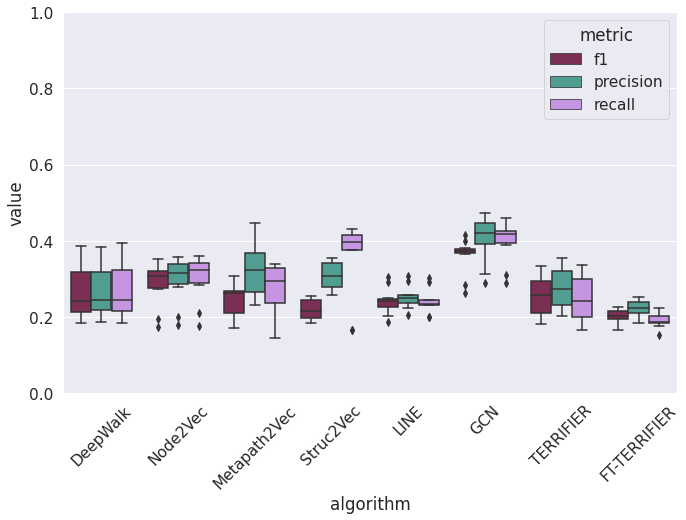

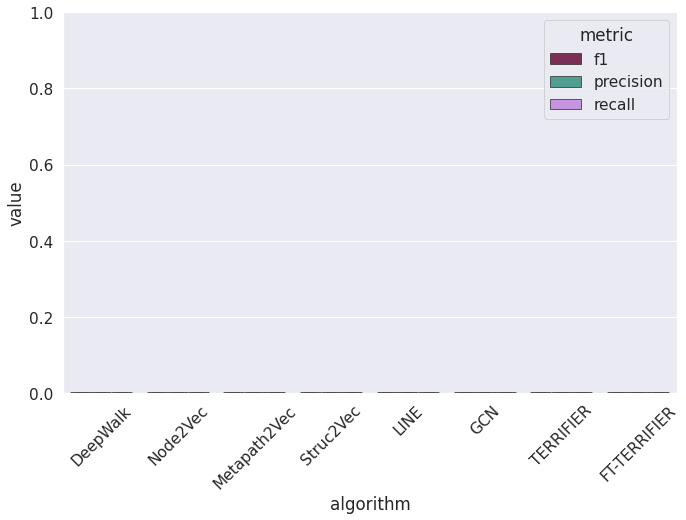

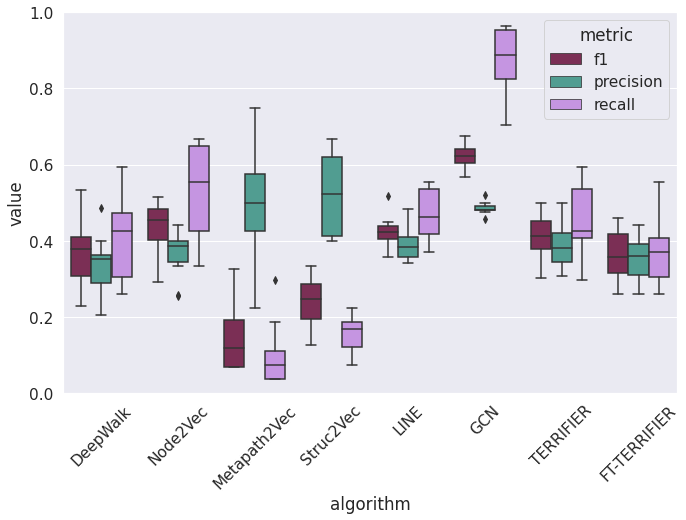

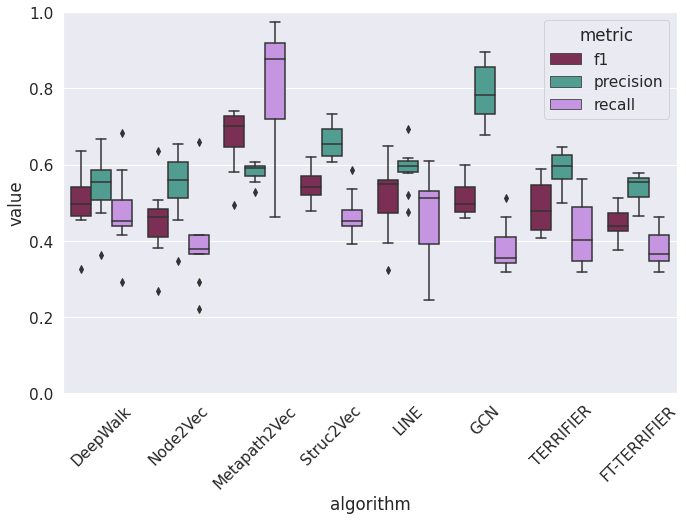

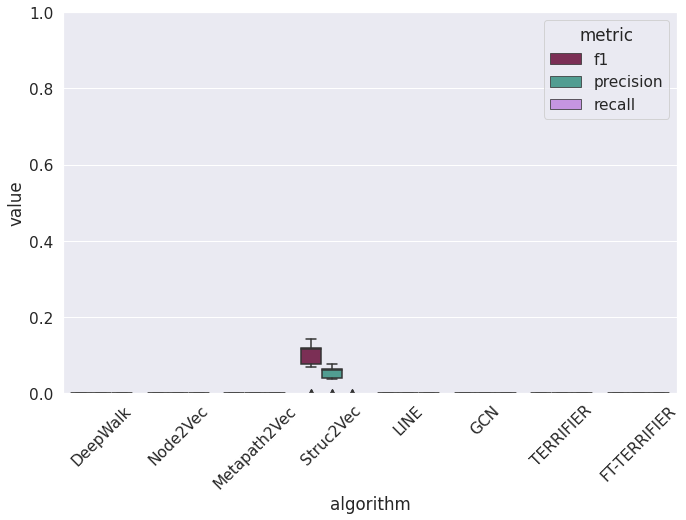

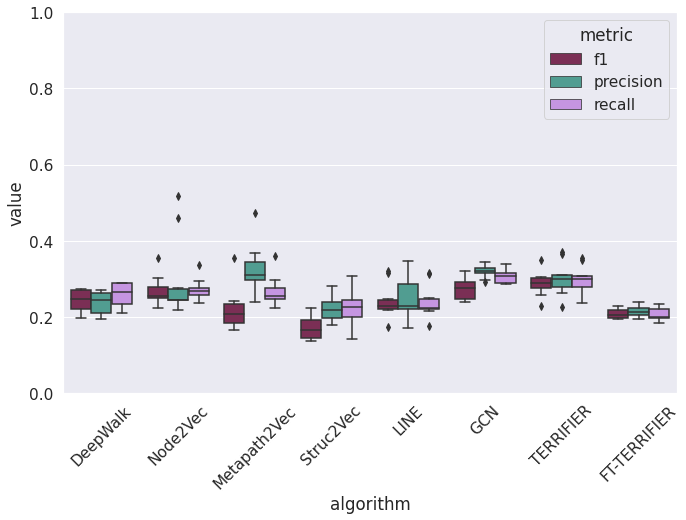

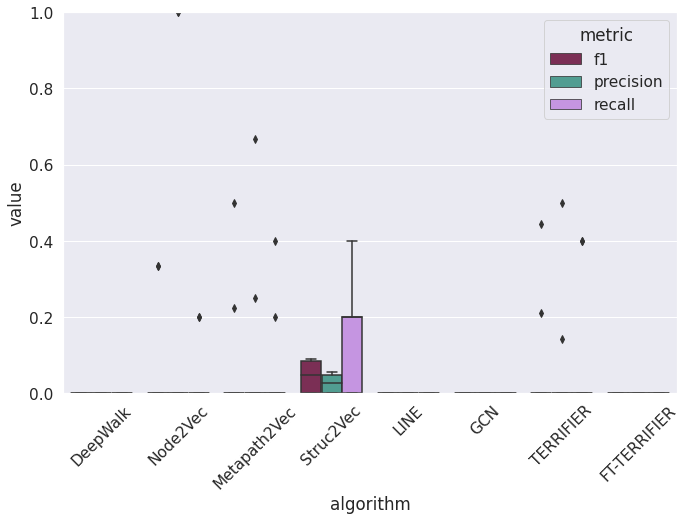

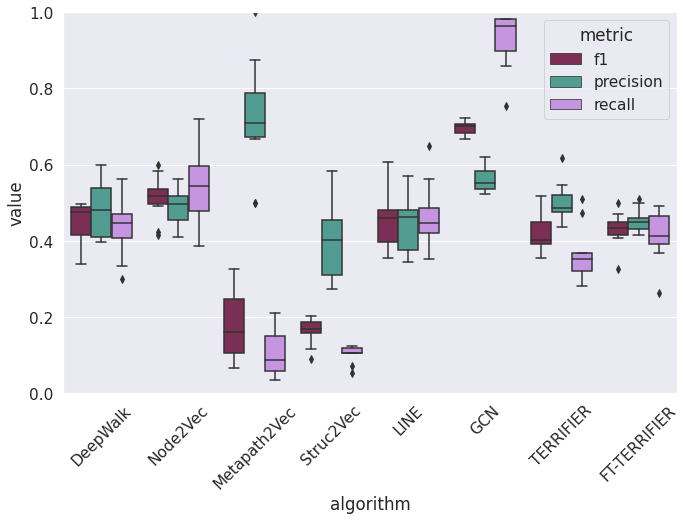

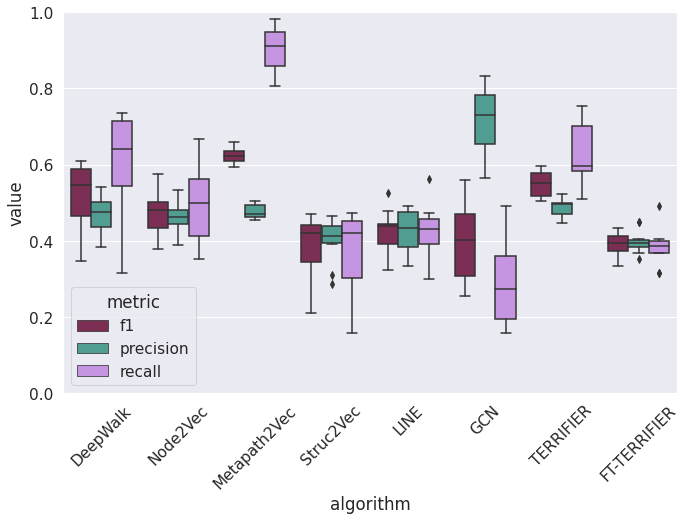

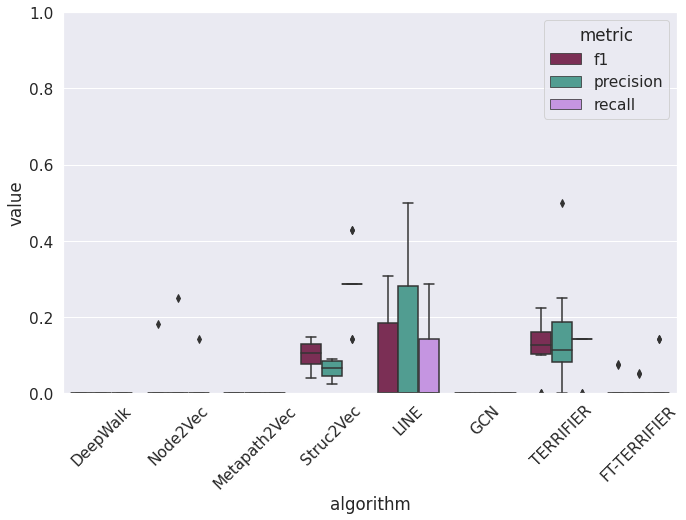

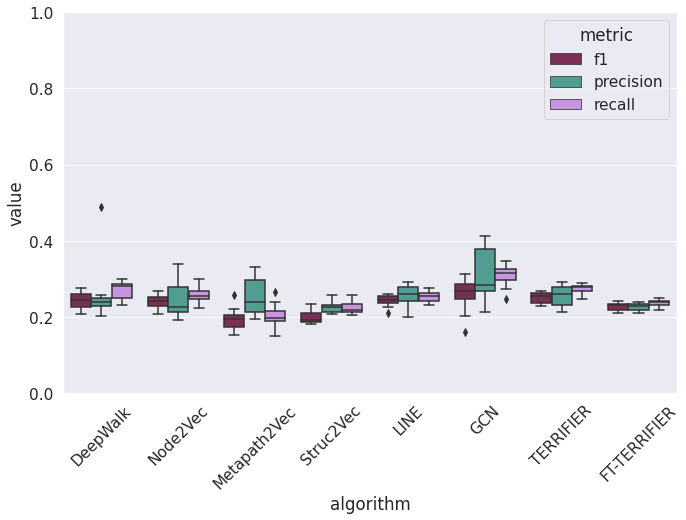

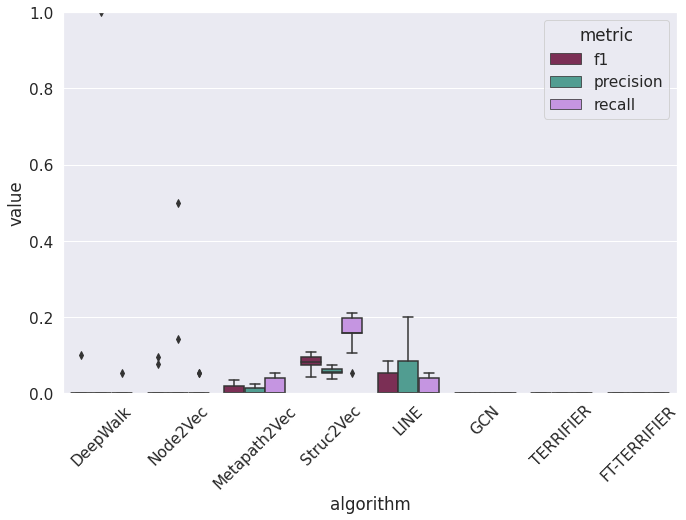

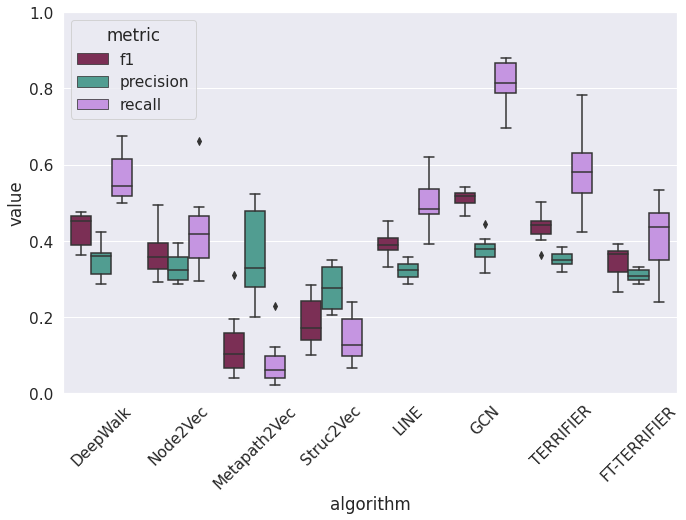

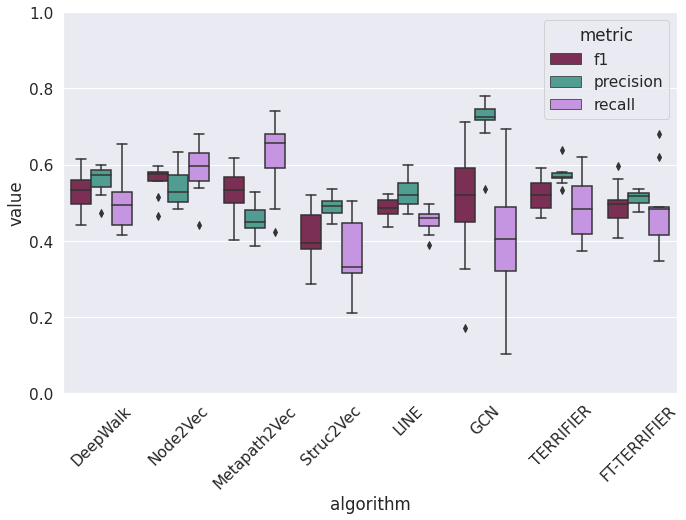

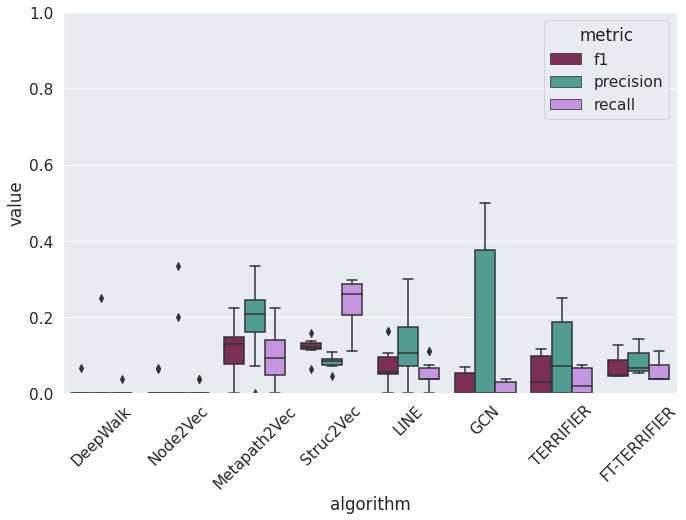

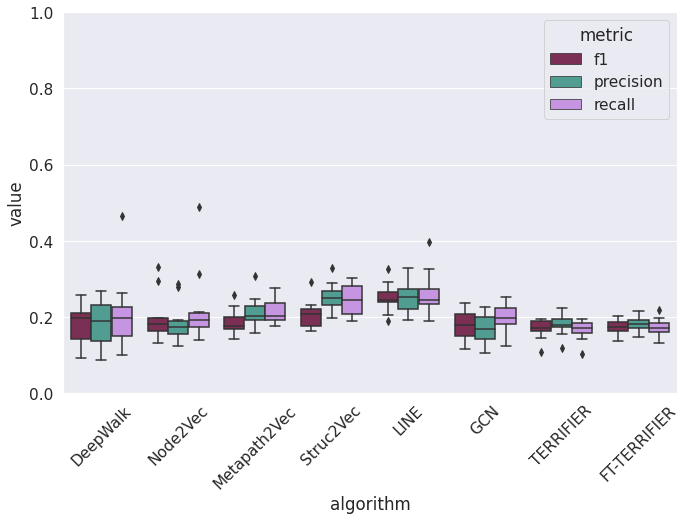

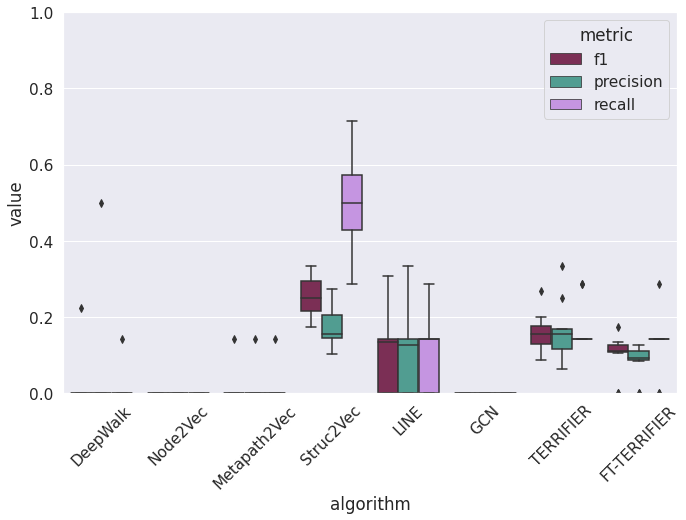

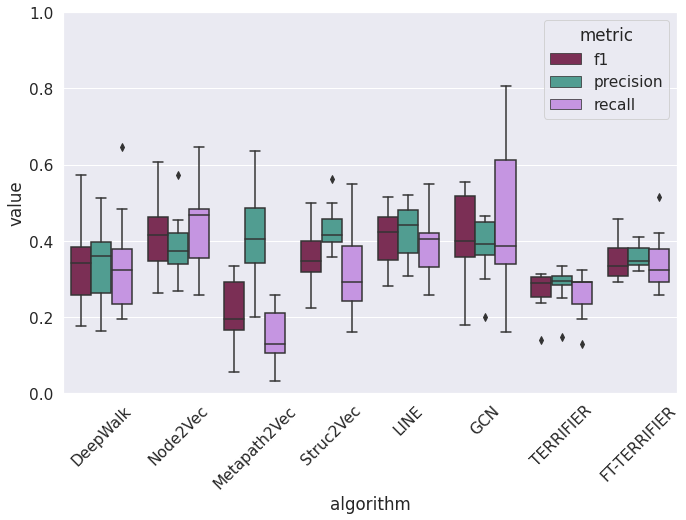

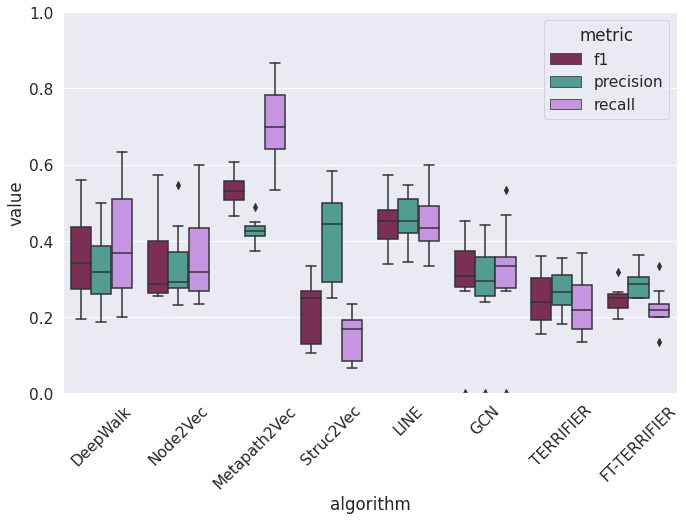

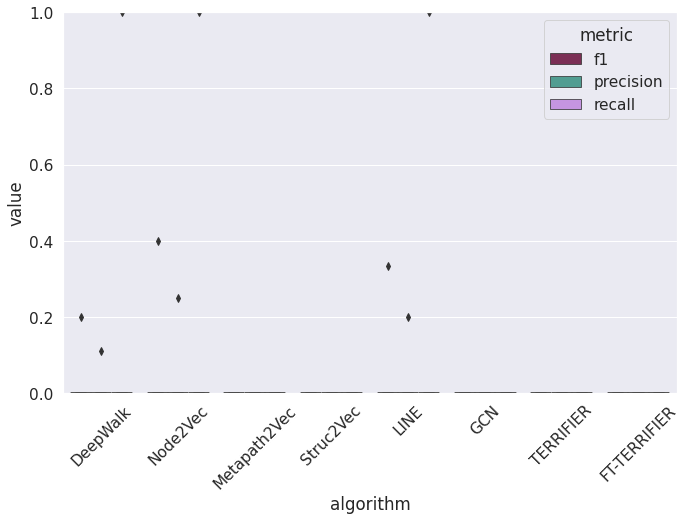

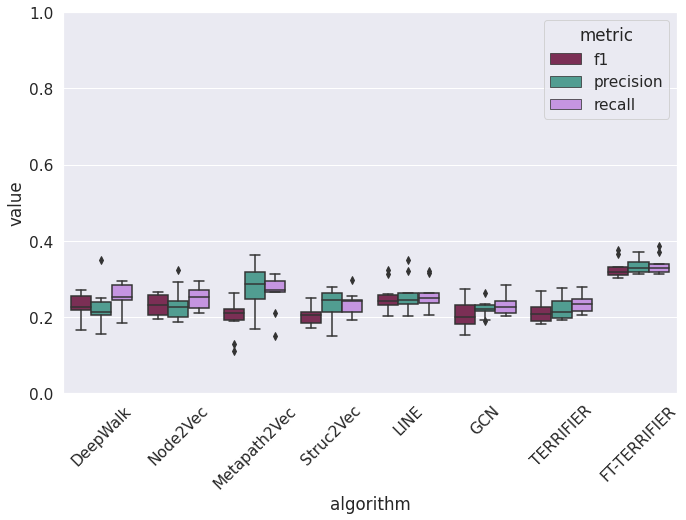

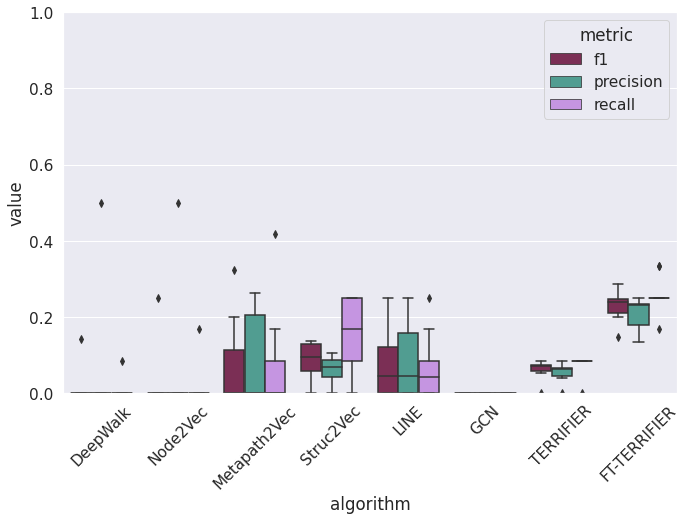

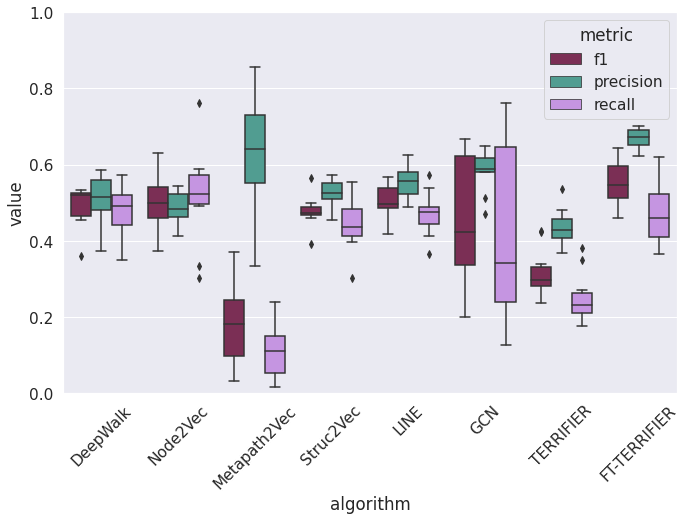

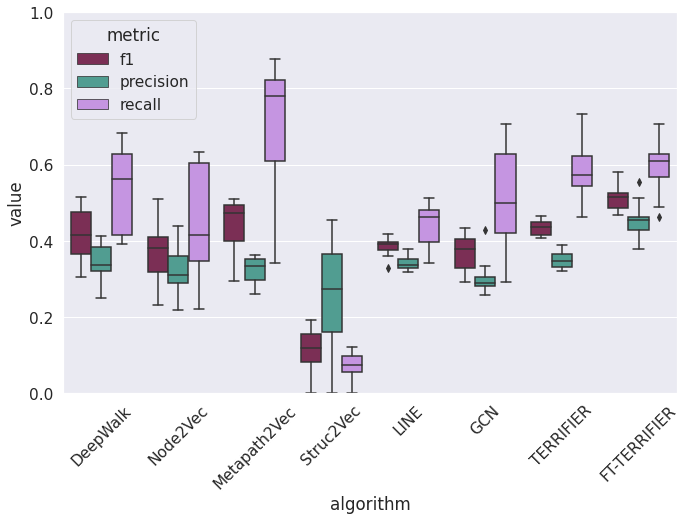

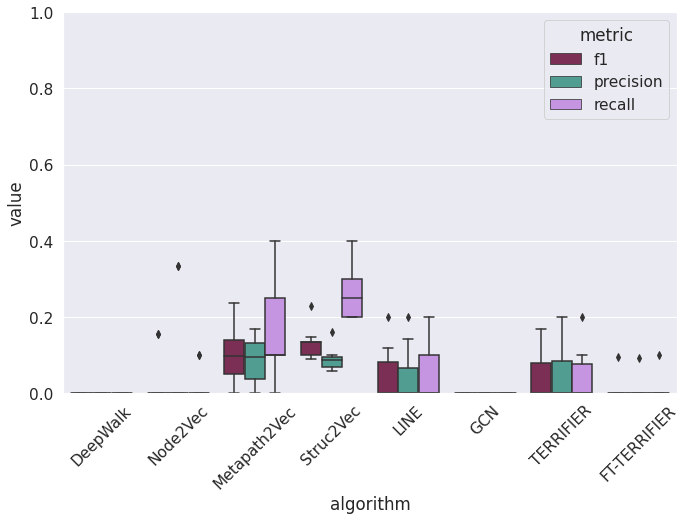

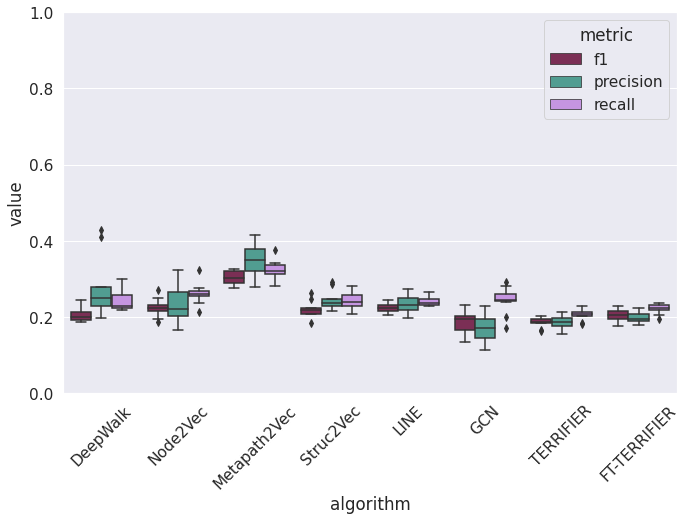

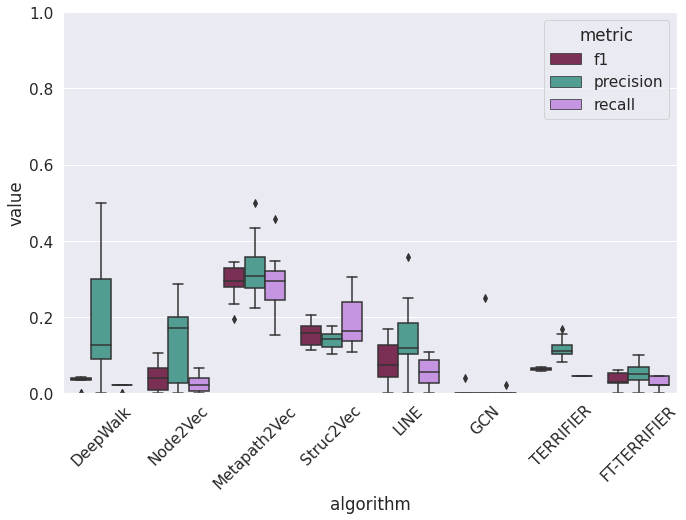

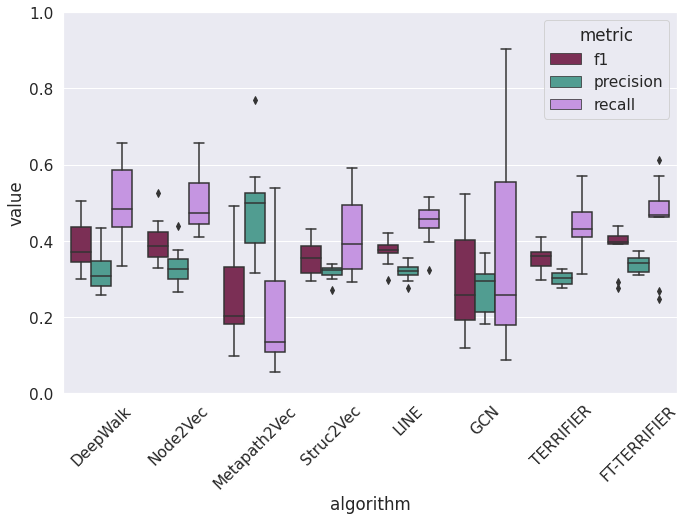

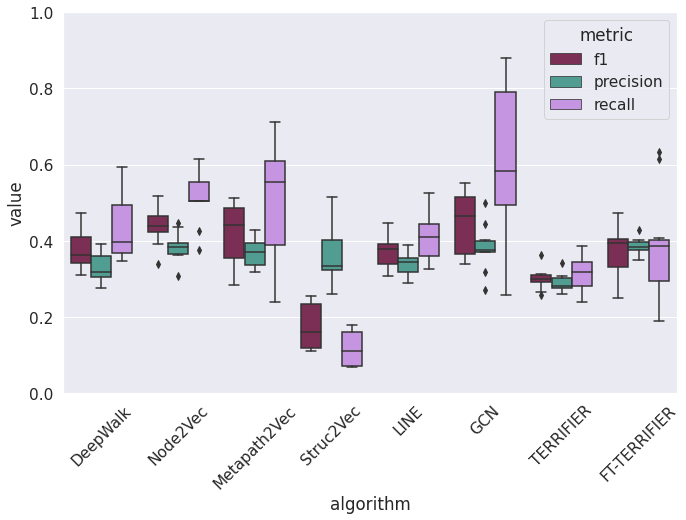

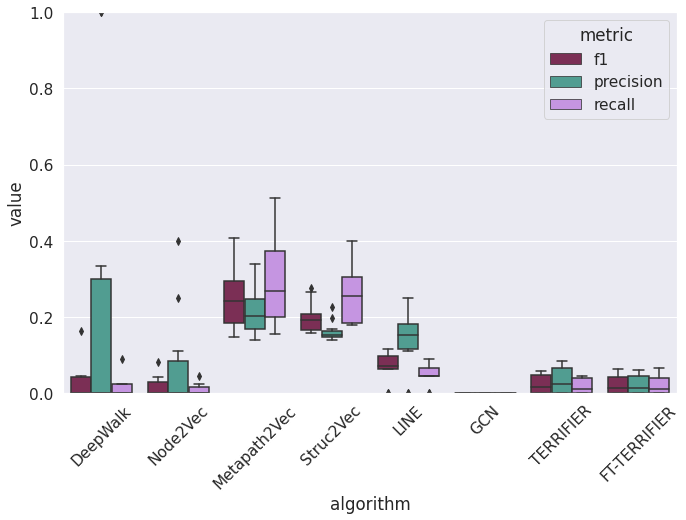

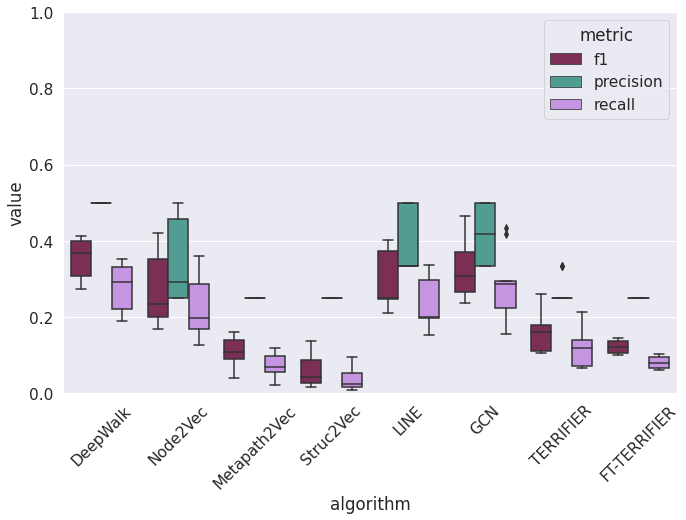

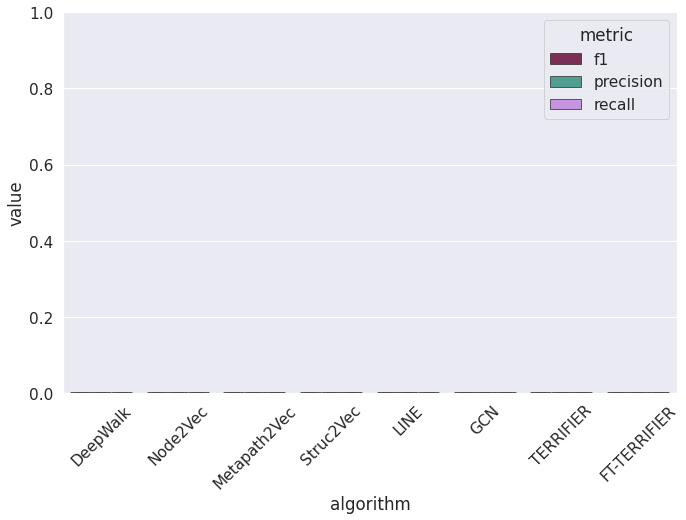

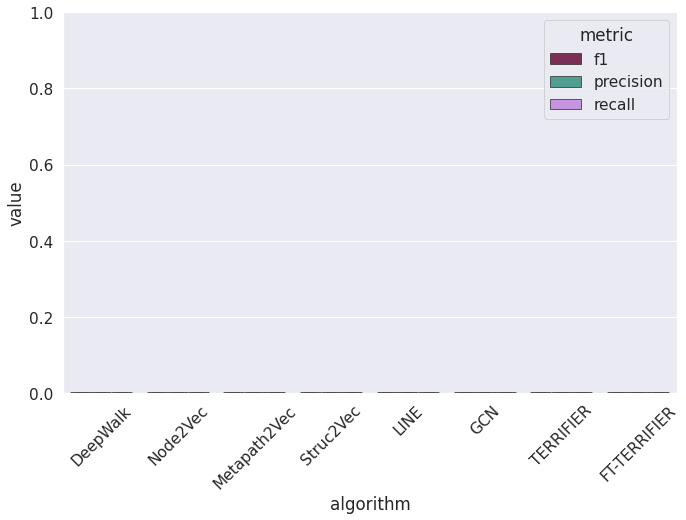

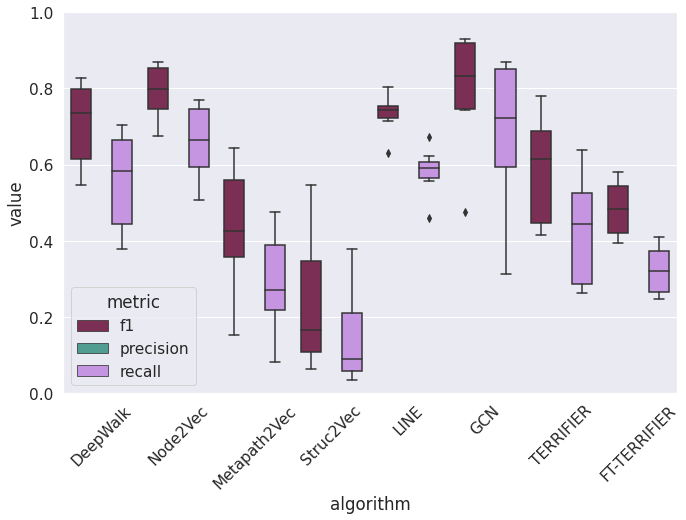

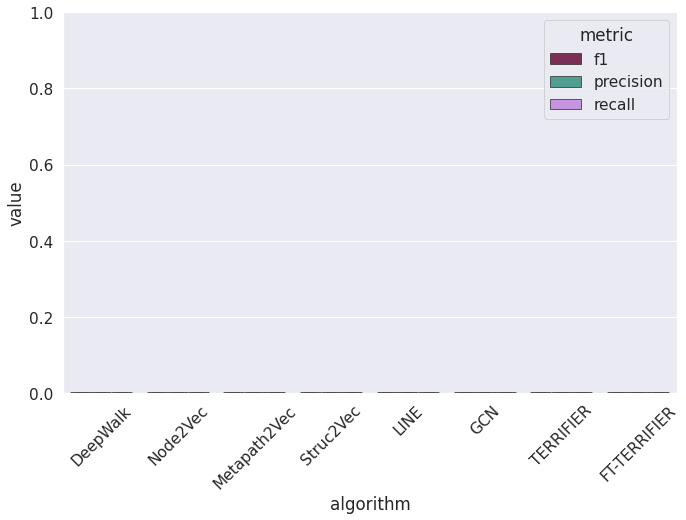

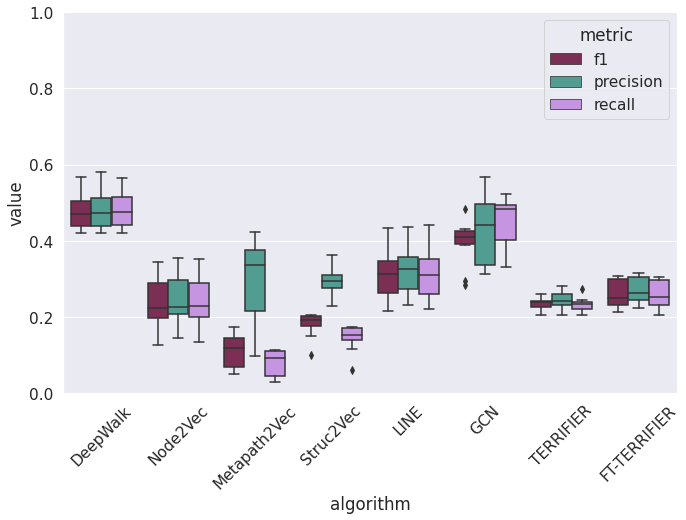

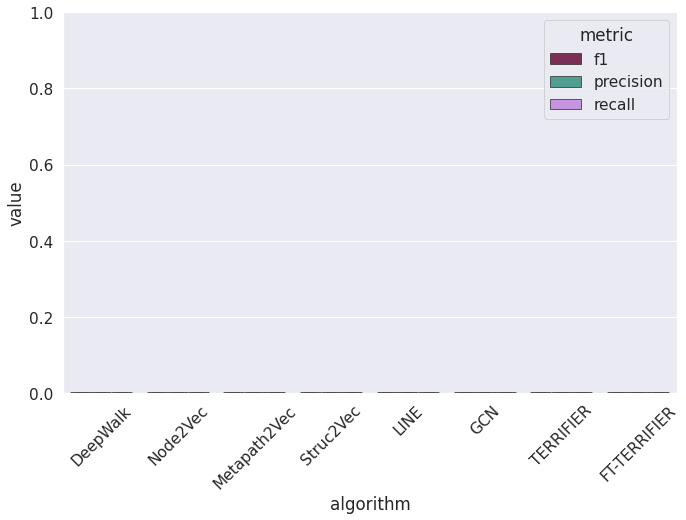

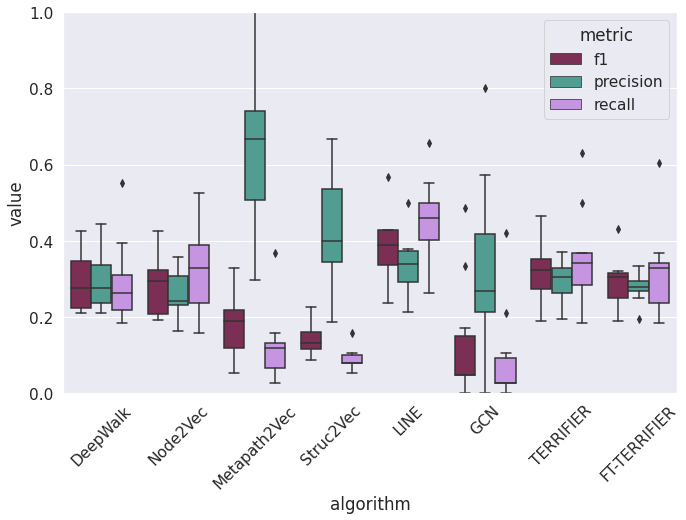

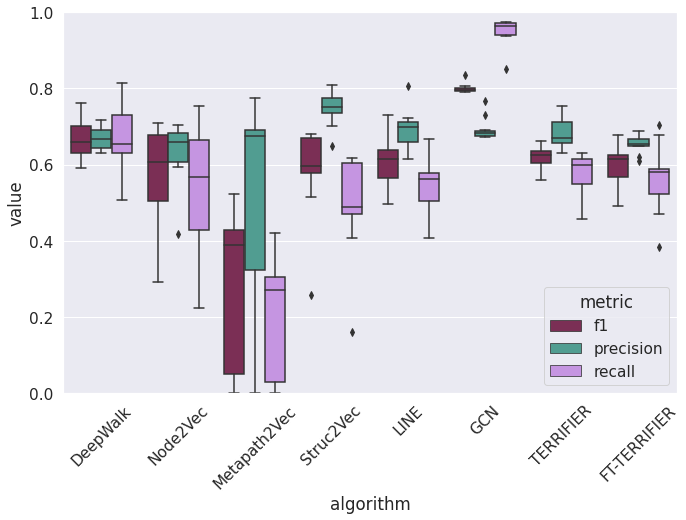

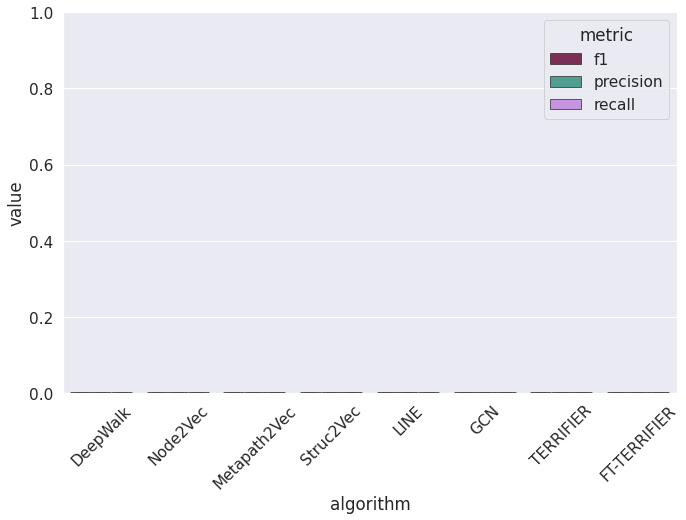

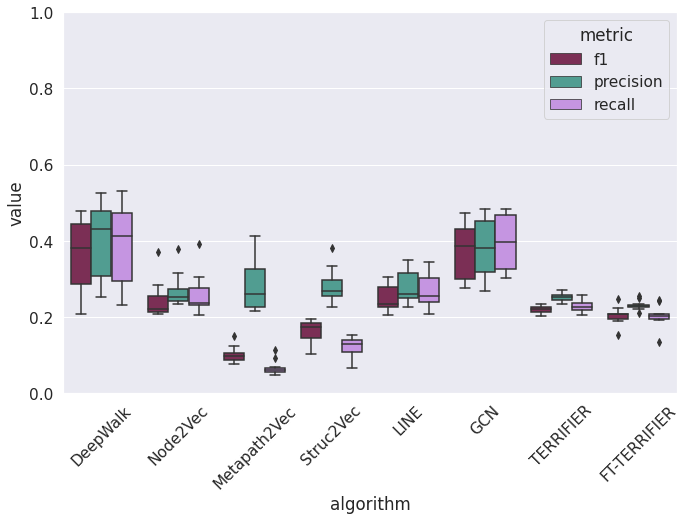

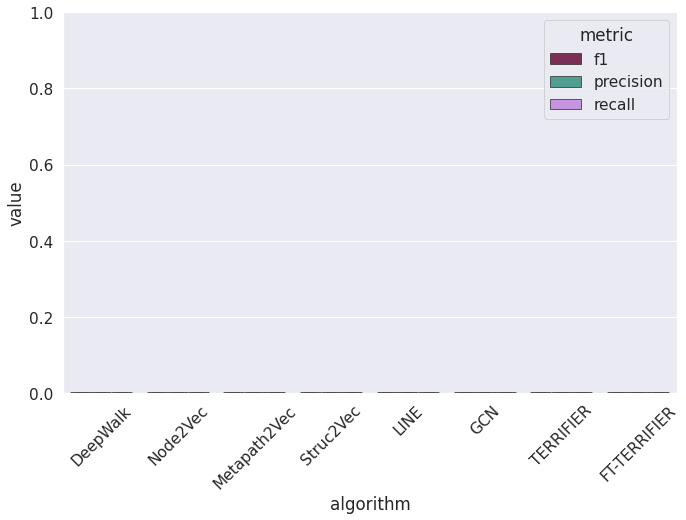

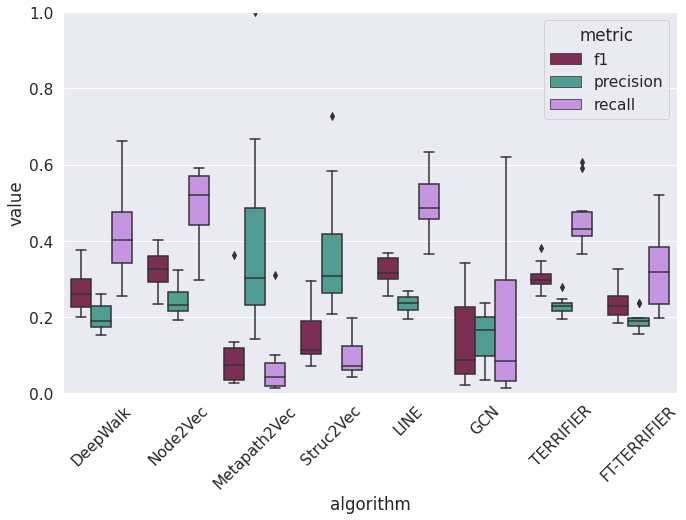

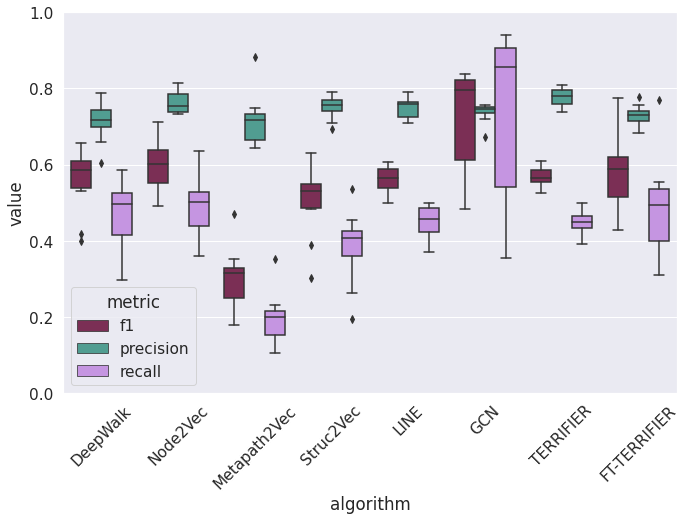

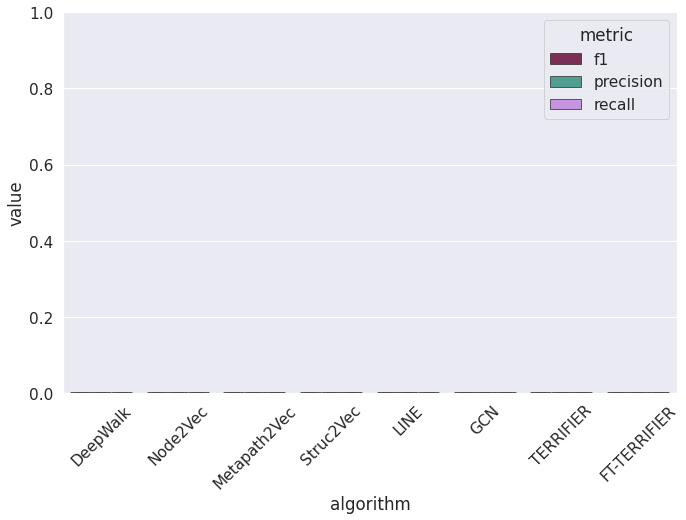

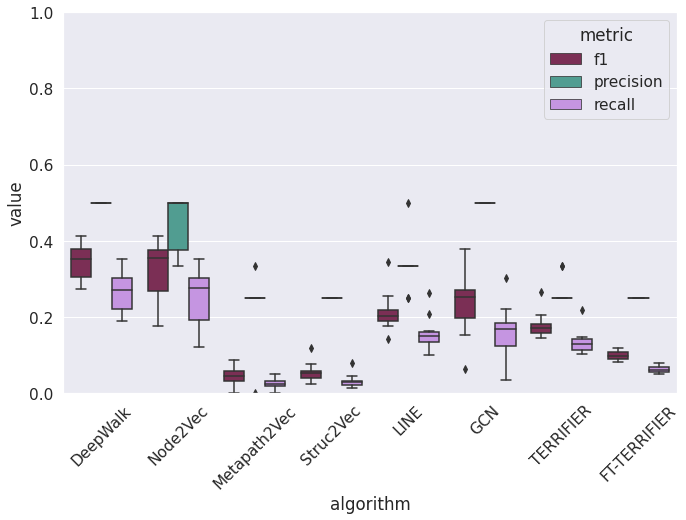

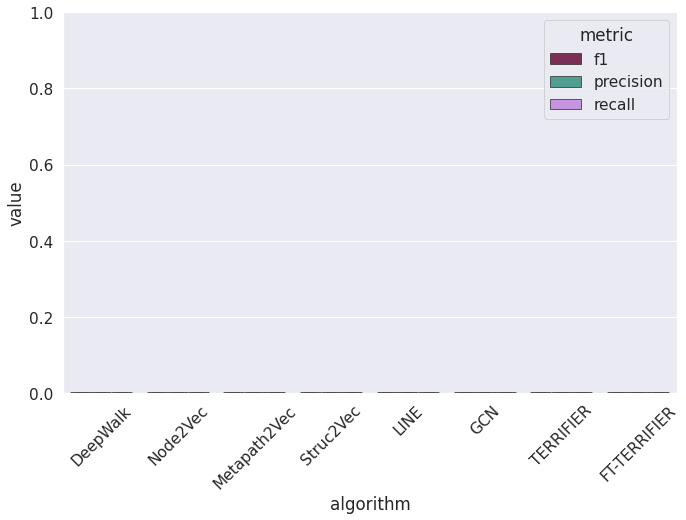

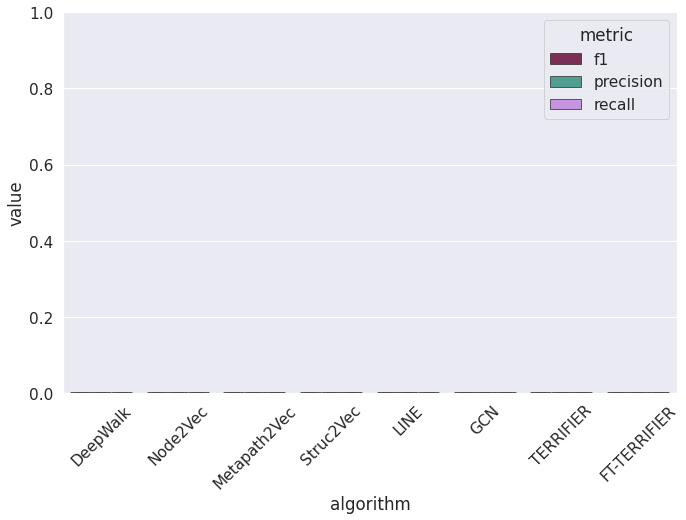

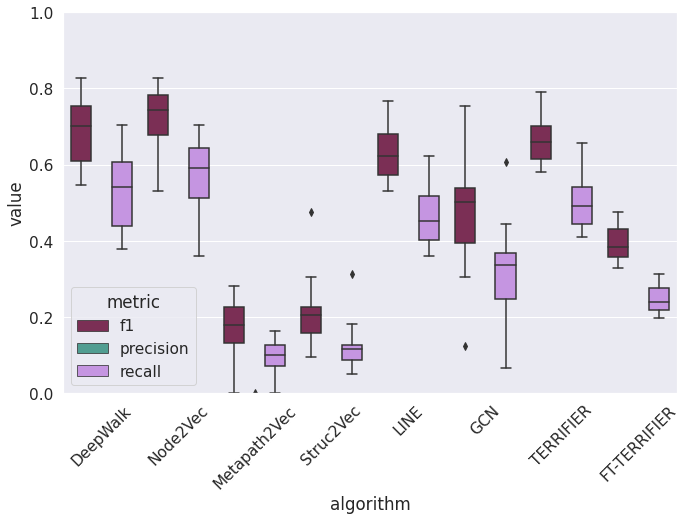

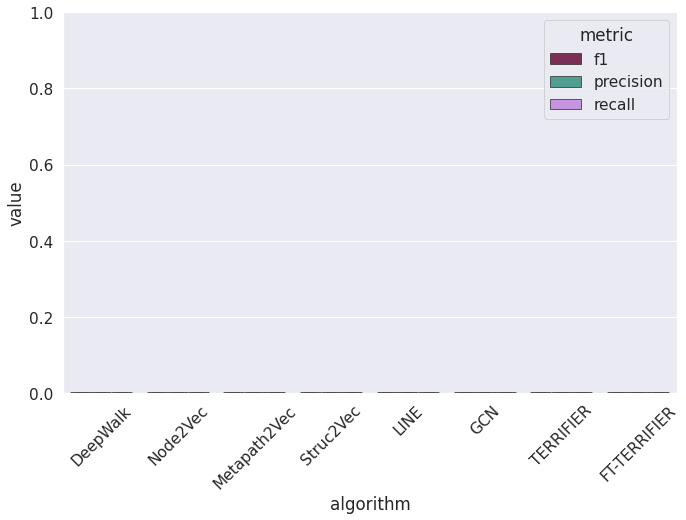

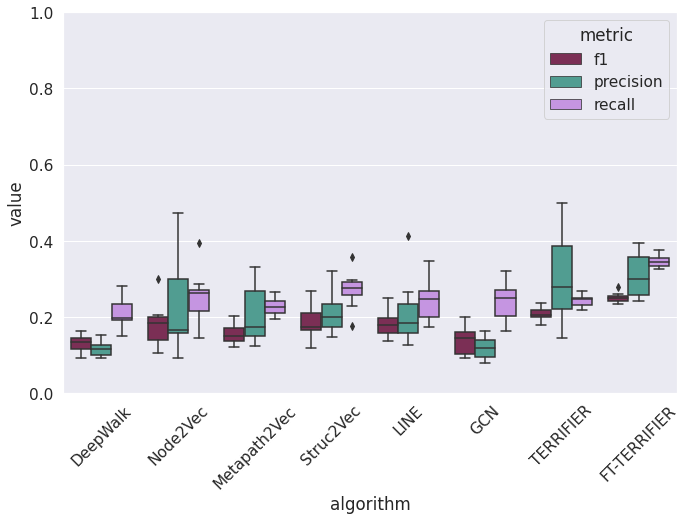

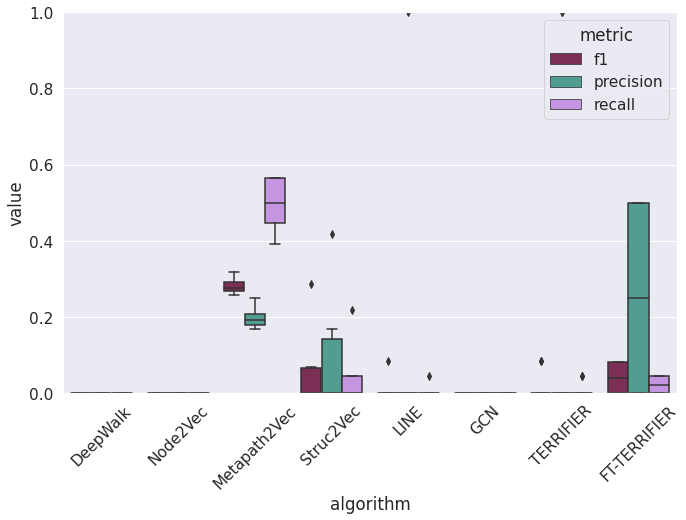

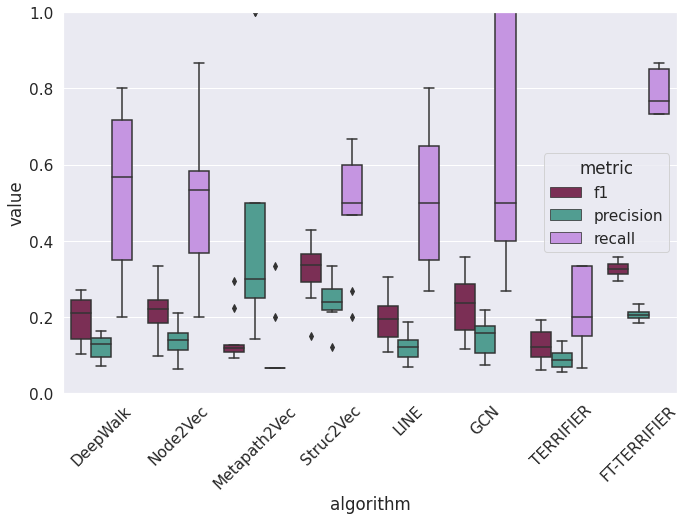

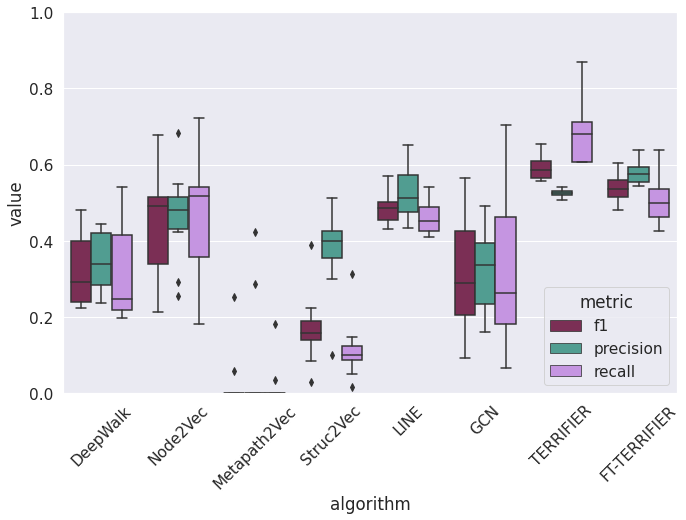

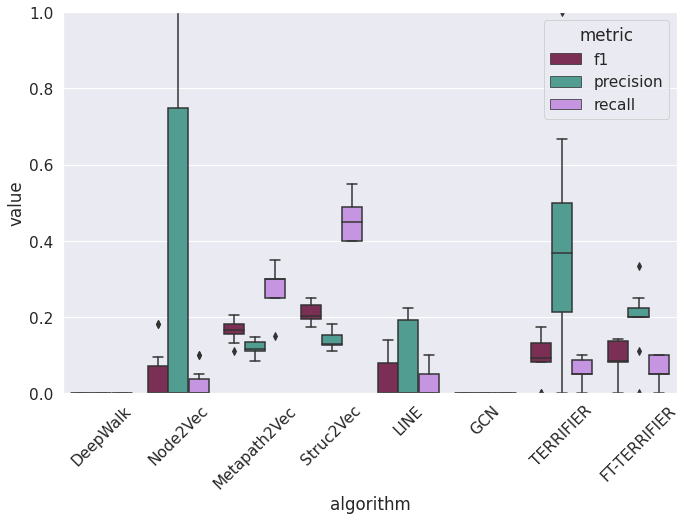

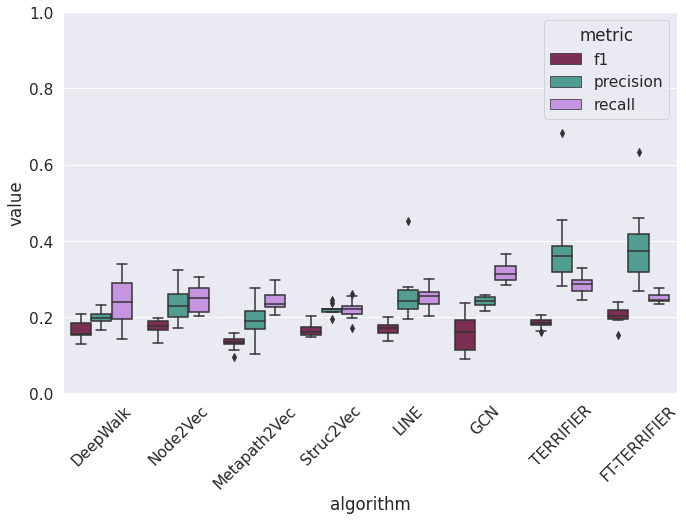

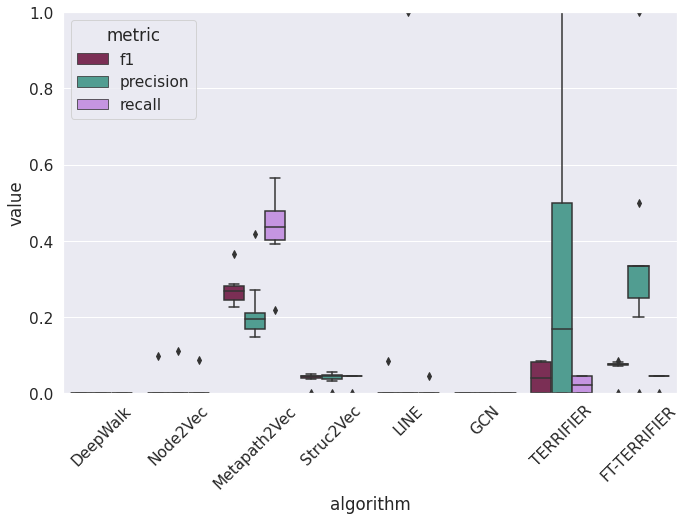

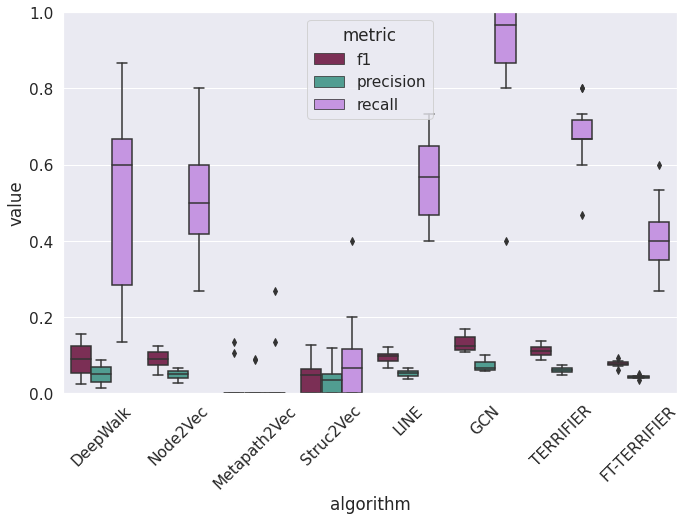

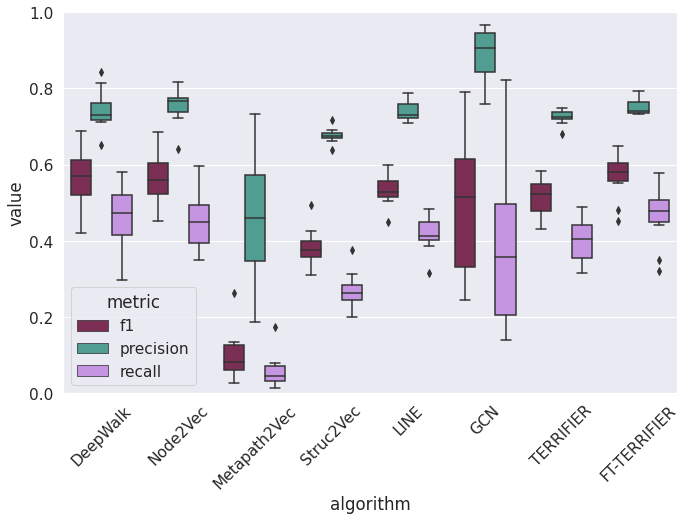

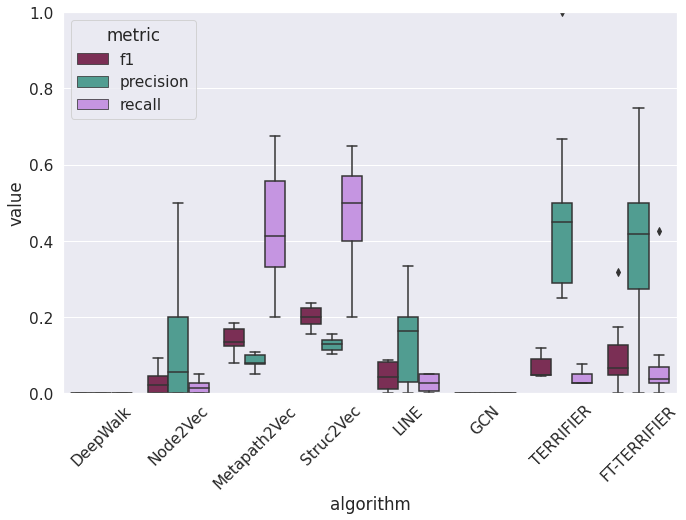

In [14]:
label_code = {
    'None': 'all',
    '[0]': 'big_down',
    '[1]': 'down',
    '[2]': 'up',
    '[3]': 'big_up',
}

intervals = ['week', 'month']
commodities = ['corn', 'soybean']
time_windows = {'month': [3, 6, 12], 'week': [12, 24, 48]}

for ida, interval in enumerate(intervals):
    for idb, commodity in enumerate(commodities):
        for idc, time_window in enumerate(time_windows[interval]):
            for idd, edge_type in enumerate(edge_types):
                for ide, label in enumerate(labels):
                    plt.figure(ida+idb+idc+idd+ide)
                    filtered_results_df = results_df[
                        ((results_df['interval'] == interval) &
                        (results_df['commodity'] == commodity) &
                        (results_df['time_window'] == time_window) &
                        (results_df['edge_type'] == edge_type) &
                        (results_df['label'] == str(label)))
                    ].reset_index(drop=True)
                    algorithm_order = {'deep_walk': 0, 'node2vec': 1, 'metapath2vec': 2, 'struc2vec': 3, 'line': 4, 'gcn': 5, 'regularization': 6, 'regularization-tuned': 7}
                    filtered_results_df['algorithm'] = pd.Categorical(filtered_results_df['algorithm'], 
                         categories=sorted(algorithm_order, key=algorithm_order.get), 
                         ordered=True)
                    filtered_results_df.sort_values(by=['metric', 'algorithm'], inplace=True)
                    g = sns.boxplot(x="algorithm", y="value", hue="metric",
                            data=filtered_results_df)
                    #g.set_title("\n".join(wrap(f'boxplot for {commodity} trend predictions performance {time_window} {interval}s ahead mesuared by the metrics f1, precision and recall considering {label_code[str(label)]} classes.')))
                    g.set(ylim=(0.0, 1.0))
                    g.set_xticklabels(['DeepWalk', 'Node2Vec', 'Metapath2Vec', 'Struc2Vec', 'LINE', 'GCN', 'TRENCHANT', 'FT-TRENCHANT'])
                    for idx, item in enumerate(g.get_xticklabels()):
                        item.set_rotation(45)
                    g.get_figure().set_size_inches(11,7)
                    g.get_figure().savefig(f'/media/pauloricardo/basement/commodities_usecase/plots/plot_{commodity}_{interval}_{time_window}_{label}_{edge_type}.pdf', bbox_inches='tight')
                    plt.show()